# Data cleaning and merging technical replicates

**Date**: written 2020-05-26  
**Author**: Katarina Braun 


## Overview
- Clean up the VCFs that the SARSquencer spits out
- Drop any SNVs not found in both replicates
- Average the frequency of the SNVs found in these replicates and report this as 'FREQ'
- Make new CSVs with these column headers: 
    1. gene 'ORF1a'
    2. POS '2772'
    3. REF 'C'
    4. ALT 'T'
    5. FREQ '1.0' = fixed 
    6. SNP 'ORF1a_C2772T_syn'
    7. % of population  '100.0'
- Make a "TV plot" figure to show comparison of SNVs and indels in replicate 1 and 2 

With the help of Katia Koelle, we've decided that iSNVs <3% and >97% in this dataset are likely not polymorphic. 

I went back to Grubaugh et al’s 2019 paper that really comprehensively measured the accuracy of PrimalSeq-based amplicon sequencing and showed, I think pretty convincingly, that “PrimalSeq can be used for accurate iSNV detection above 3% when using at least two technical replicates.” I am thinking this is probably the best way to move forward with all of our within-host data — using intersection iSNVs between 3 and 97%.

[Link](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1618-7) to the Grubaugh et al paper discussed above. 

### Reference 

Everything was mapped to the Japan reference sequence (MW219695.1) -- this is the consensus sequence for the inoculum that was used to infect the cats we are evaluating here. 

Nucleotide numbering scheme will therefore differ from the the numbering scheme used in Nextstrain. 

[Link](https://www.ncbi.nlm.nih.gov/nuccore/MW219695.1) to GenBank accession page for the reference sequence.

[Link](https://www.nejm.org/doi/full/10.1056/nejmc2013400) to the original NEJM report on transmission of SARS-CoV-2 in domestic cats by Halfmann et al. 


## Input: 

1. SNV files in VCF format located here: 
    - `SARSCoV2_transmission_in_domestic_cats/data_derived/*`

## Output: 

1. Cleaned generated from VCF input files will be located here:       
     - `SARSCoV2_transmission_in_domestic_cats/data_derived/cleaned/*`


2. TV plot comparing SNV/indel data across technical replicates:   
     - `SARSCoV2_in_domestic_cats/figure/replicates.pdf`


### import modules and dependencies

In [32]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import glob
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pathlib import Path
from os.path import splitext
from functools import reduce
from pandas.api.types import is_numeric_dtype
import warnings
from pandas.core.common import SettingWithCopyWarning
from matplotlib.font_manager import FontProperties 
from matplotlib import cm
import itertools
from matplotlib import container
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib as mpl
from pandas.plotting import table

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

## data cleaning

### define functions for data cleaning

In [41]:
# load all text files in a directory into Pandas dataframes 
# path should be set to path to the text files that you would like to load into dataframes 
# set this function equal to some variable which will then be callable as a list of the dataframes 
# the specific sample name can be found within the VCF or dataframe
def load_dataframes(path):
    filelist = [os.path.splitext(file)[0] for file in os.listdir(path) if file.endswith('.vcf.recode.vcf')]
    list_of_DFs = []
    for file in filelist: 
        DF = path + '/' + file + '.vcf'
        file = pd.read_csv(DF, header=0, sep='\t', low_memory=False, skiprows=56)
        list_of_DFs.append(file)
    print(filelist)
    return(list_of_DFs)

# manipulate SNV dataframes 
# first run load_dataframes and generate a variable for the list of DFs, then feed that variable 
# into this function to clean the dataframe up and save to new CSV 
def clean_dataframes(path, list_of_DFs):
    if not os.path.exists(path + '/cleaned'):
            os.makedirs(path + '/cleaned')
    for DF in list_of_DFs:
        sample = DF.columns[9]
        DF2 = DF.drop(['#CHROM', 'ID', 'QUAL', 'FILTER', 'FORMAT'], axis=1)
        DF2 = DF2[['POS', 'REF', 'ALT']] #POS, REF, ALT
        DF3 = DF['INFO'].str.split(';', expand=True) #nothing here (just need this DF to expand column 26)
        DF5 = DF3[[12]] #SNP frequency 
        DF5 = DF5.rename(columns={12:'FREQ'})
        DF4 = DF3[26].str.split('|', expand=True) #1=annotation, 3=gene, 9=nt_change, 10=aa_change
        DF4 = DF4[[1,3,9,10]]
        DF4 = DF4.rename(columns={1:'annotation', 3:'gene', 9:'nt_change', 10:'aa_change'})
        DF = pd.concat([DF2, DF4, DF5], axis=1, join='inner')
        DF['FREQ'].replace(regex=True, inplace=True, to_replace=r'AF=', value='')
        DF['nt_change'].replace(regex=True, inplace=True, to_replace=r'c.', value='')
        DF['nt_change'] = DF['nt_change'].str.replace('\d+', '') # get rid of POS in nt_change column 
        DF['aa_change'].replace(regex=True, inplace=True, to_replace=r'p.', value='')
        DF['annotation'].replace(regex=True, inplace=True, to_replace=r'_variant', value='')
        DF['annotation'].replace(regex=True, inplace=True, to_replace=r'_gained', value='')
        DF['annotation'].replace(regex=True, inplace=True, to_replace=r'_', value='-')
        DF['nt_change'].replace(regex=True, inplace=True, to_replace=r'_', value='-')
        DF['aa_change'].replace(regex=True, inplace=True, to_replace=r'_', value='-')
        DF['POS'] = DF['POS'].apply(str)
        DF['SNP'] = DF['gene'] + '_' + DF['POS'] + ':' + DF['REF'] + '>' + DF['ALT'] +'_' + DF['aa_change'] + '_' + DF['annotation']
        DF["FREQ"] = pd.to_numeric(DF["FREQ"]) #convert FREQ column from object type to int
        DF = DF[DF.FREQ >= 0.03] # drop any variants that are ≤3% frequency (they may be erroneous)
        DF.to_csv(path + '/cleaned/' + sample + '-cleaned.csv', sep='\t')
#

### VCF file data-cleaning

In [42]:
# generate a list of dataframes, loaded from Illumina VCF files 
list_of_DFs = load_dataframes('../data_derived')

['1_1A.vcf.recode', '1_1B.vcf.recode', '1_2A.vcf.recode', '1_2B.vcf.recode', '1_3A.vcf.recode', '1_3B.vcf.recode', '1_4A.vcf.recode', '1_4B.vcf.recode', '1_5A.vcf.recode', '1_5B.vcf.recode', '1_6A.vcf.recode', '1_6B.vcf.recode', '1_7A.vcf.recode', '1_7B.vcf.recode', '1_8A.vcf.recode', '1_8B.vcf.recode', '2_1A.vcf.recode', '2_1B.vcf.recode', '2_2A.vcf.recode', '2_2B.vcf.recode', '2_3A.vcf.recode', '2_3B.vcf.recode', '2_4A.vcf.recode', '2_4B.vcf.recode', '2_5A.vcf.recode', '2_5B.vcf.recode', '2_6A.vcf.recode', '2_6B.vcf.recode', '2_7A.vcf.recode', '2_7B.vcf.recode', '2_8A.vcf.recode', '2_8B.vcf.recode', '3_1A.vcf.recode', '3_1B.vcf.recode', '3_2A.vcf.recode', '3_2B.vcf.recode', '3_3A.vcf.recode', '3_3B.vcf.recode', '3_4A.vcf.recode', '3_4B.vcf.recode', '3_5A.vcf.recode', '3_5B.vcf.recode', '3_7A.vcf.recode', '3_7B.vcf.recode', '3_8A.vcf.recode', '3_8B.vcf.recode', '4_3A.vcf.recode', '4_3B.vcf.recode', '4_4A.vcf.recode', '4_4B.vcf.recode', '4_5A.vcf.recode', '4_5B.vcf.recode', '4_6A.vcf.r

In [43]:
# clean up all of the dataframes and save to new CSV files 
clean_dataframes('../data_derived/', list_of_DFs)

# function to find intersection SNVs

In [44]:
def find_intersection(path, df_list):
    # create list of unique dataframe identifiers – this enables easy pairing of csvs
    value_list=[]
    value_set=[]
    for item in df_list:
        if "A" in item:
            value = item.replace("A-cleaned.csv","")
        if "B" in item:
            value = item.replace("B-cleaned.csv","")
            value_list.append(value)
#             print(value_list)
        value_set=set(value_list)   
#             print(value_list)
    for item in value_set:
        # create dataframes from csv files
        rep1_path = path + item + 'A-cleaned.csv'
        rep1_df = pd.read_csv(rep1_path, sep='\t')
        rep2_path = path + item + 'B-cleaned.csv'
        rep2_df = pd.read_csv(rep2_path, sep='\t')
        # clean up column names
        rep1_df = rep1_df.rename(columns={'FREQ': '%-rep1'})
        rep2_df = rep2_df.rename(columns={'FREQ': '%-rep2'})
        A1_1m = rep1_df[['SNP', '%-rep1', 'POS']]
        B1_1m = rep2_df[['SNP', '%-rep2', 'POS']]
        df1_1 = pd.merge(A1_1m, B1_1m, on='SNP', how='outer')
        df1_1['POS_x'] = df1_1['POS_x'].fillna(df1_1['POS_y'])
        df1_1 = df1_1[['SNP', 'POS_x', '%-rep1', '%-rep2']]
        df1_1 = df1_1.sort_values('POS_x', ascending=True)
        df1_1['FREQ'] = df1_1[['%-rep1', '%-rep2']].mean(axis=1)
        df1_1 = df1_1.rename(columns={'%-rep1': 'rep1_percent', '%-rep2': 'rep2_percent'})
        df1_1.loc[df1_1.FREQ >= 0.97, 'FREQ'] = 1.0 # any SNVs average >0.97 FREQ are likely fixed so I'll rewrite anything >0.97 to 1.0
        df1_1 = df1_1.rename(columns={'FREQ': '%'})
        df1_1_intersection = df1_1.dropna()
#         print(df1_1_intersection)
        df1_1_intersection.to_csv(path + item + '-intersection.csv', sep='\t')

In [46]:
# make a list of the cleaned CSV files 

directory = '../data_derived/cleaned/'
files_dir =  os.listdir(directory)
newlist = []
for names in files_dir:
    if names.endswith(".csv"):
        newlist.append(names)
print(newlist)

['1_1A-cleaned.csv', '1_1B-cleaned.csv', '1_2A-cleaned.csv', '1_2B-cleaned.csv', '1_3A-cleaned.csv', '1_3B-cleaned.csv', '1_4A-cleaned.csv', '1_4B-cleaned.csv', '1_5A-cleaned.csv', '1_5B-cleaned.csv', '1_6A-cleaned.csv', '1_6B-cleaned.csv', '1_7A-cleaned.csv', '1_7B-cleaned.csv', '1_8A-cleaned.csv', '1_8B-cleaned.csv', '2_1A-cleaned.csv', '2_1B-cleaned.csv', '2_2A-cleaned.csv', '2_2B-cleaned.csv', '2_3A-cleaned.csv', '2_3B-cleaned.csv', '2_4A-cleaned.csv', '2_4B-cleaned.csv', '2_5A-cleaned.csv', '2_5B-cleaned.csv', '2_6A-cleaned.csv', '2_6B-cleaned.csv', '2_7A-cleaned.csv', '2_7B-cleaned.csv', '2_8A-cleaned.csv', '2_8B-cleaned.csv', '3_1A-cleaned.csv', '3_1B-cleaned.csv', '3_2A-cleaned.csv', '3_2B-cleaned.csv', '3_3A-cleaned.csv', '3_3B-cleaned.csv', '3_4A-cleaned.csv', '3_4B-cleaned.csv', '3_5A-cleaned.csv', '3_5B-cleaned.csv', '3_7A-cleaned.csv', '3_7B-cleaned.csv', '3_8A-cleaned.csv', '3_8B-cleaned.csv', '4_3A-cleaned.csv', '4_3B-cleaned.csv', '4_4A-cleaned.csv', '4_4B-cleaned.csv',

In [47]:
find_intersection('../data_derived/cleaned/', newlist)

# Plot variant frequencies in replicate A and replicate B

In [48]:
colors1 = '#A86566' #red
colors2 = '#C87F7F' #light red
colors3 = '#CB997D' #crisp orange
colors4 = '#CCBA85' #warm yellow
colors5 = '#A4A58C' #moss green 
colors6 = '#8DA395' #warm mint green 
colors7 = '#8B9AA0' #stone blue
colors8 = '#59667C' #faded navy
colors9 = '#938AA0' #lavender
colors10 = '#715C7C' #purple

## cat 1

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


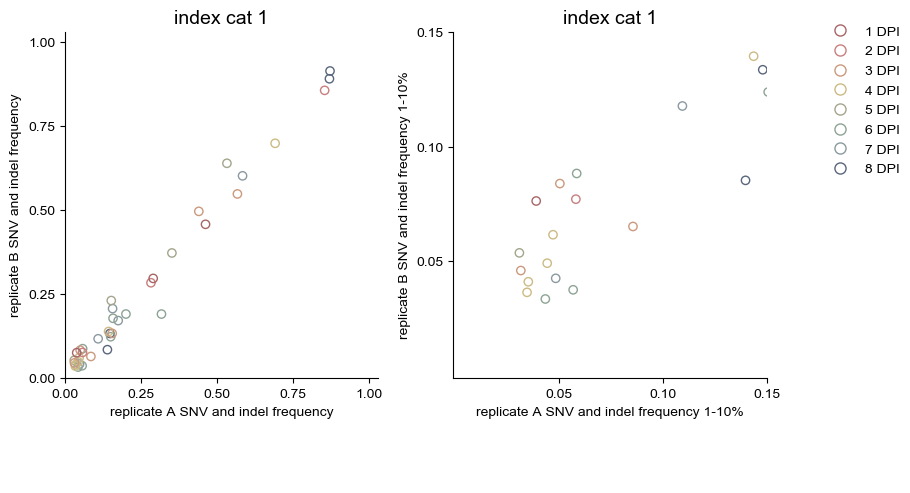

In [49]:
# generate a figure comparing SNV frequencies across replicates
fig1 = plt.figure(figsize=(8,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 8)

ax1 = fig1.add_subplot(gs[0,0:4]) # JT/TV plot
ax2 = fig1.add_subplot(gs[0,4:8]) # JT/TV plot ZOOM

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)

# load DFs
df1_1 = pd.read_csv("../data_derived/cleaned/1_1-intersection.csv", header=0, sep='\t')
df1_2 = pd.read_csv("../data_derived/cleaned/1_2-intersection.csv", header=0, sep='\t')
df1_3 = pd.read_csv("../data_derived/cleaned/1_3-intersection.csv", header=0, sep='\t')
df1_4 = pd.read_csv("../data_derived/cleaned/1_4-intersection.csv", header=0, sep='\t')
df1_5 = pd.read_csv("../data_derived/cleaned/1_5-intersection.csv", header=0, sep='\t')
df1_6 = pd.read_csv("../data_derived/cleaned/1_6-intersection.csv", header=0, sep='\t')
df1_7 = pd.read_csv("../data_derived/cleaned/1_7-intersection.csv", header=0, sep='\t')
df1_8 = pd.read_csv("../data_derived/cleaned/1_8-intersection.csv", header=0, sep='\t')
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# FOR PLOT replicate plot
ax1.scatter(df1_8.rep1_percent, df1_8.rep2_percent, edgecolor=colors8, facecolor='none')
ax2.scatter(df1_8.rep1_percent, df1_8.rep2_percent, edgecolor=colors8, facecolor='none')

ax1.scatter(df1_7.rep1_percent, df1_7.rep2_percent, edgecolor=colors7, facecolor='none')
ax2.scatter(df1_7.rep1_percent, df1_7.rep2_percent, edgecolor=colors7, facecolor='none')

ax1.scatter(df1_6.rep1_percent, df1_6.rep2_percent, edgecolor=colors6, facecolor='none')
ax2.scatter(df1_6.rep1_percent, df1_6.rep2_percent, edgecolor=colors6, facecolor='none')

ax1.scatter(df1_5.rep1_percent, df1_5.rep2_percent, edgecolor=colors5, facecolor='none')
ax2.scatter(df1_5.rep1_percent, df1_5.rep2_percent, edgecolor=colors5, facecolor='none')

ax1.scatter(df1_4.rep1_percent, df1_4.rep2_percent, edgecolor=colors4, facecolor='none')
ax2.scatter(df1_4.rep1_percent, df1_4.rep2_percent, edgecolor=colors4, facecolor='none')

ax1.scatter(df1_3.rep1_percent, df1_3.rep2_percent, edgecolor=colors3, facecolor='none')
ax2.scatter(df1_3.rep1_percent, df1_3.rep2_percent, edgecolor=colors3, facecolor='none')

ax1.scatter(df1_2.rep1_percent, df1_2.rep2_percent, edgecolor=colors2, facecolor='none')
ax2.scatter(df1_2.rep1_percent, df1_2.rep2_percent, edgecolor=colors2, facecolor='none')

ax1.scatter(df1_1.rep1_percent, df1_1.rep2_percent, edgecolor=colors1, facecolor='none')
ax2.scatter(df1_1.rep1_percent, df1_1.rep2_percent, edgecolor=colors1, facecolor='none')

# edit the axes - ax1
ax1.set_title('index cat 1', fontname='Arial', fontsize=14)
ax1.set_ylabel('replicate B SNV and indel frequency', fontname='Arial', fontsize=10)
ax1.set_xlabel('replicate A SNV and indel frequency', fontname='Arial', fontsize=10)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(0.001,1.03)
ax1.set_yticks([0, 0.25, 0.50, 0.75, 1.0])
ax1.set_xlim(0.001,1.03)
ax1.set_xticks([0, 0.25, 0.50, 0.75, 1.0])

# edit the axes - ax2
ax2.set_title('index cat 1', fontname='Arial', fontsize=14)
ax2.set_ylabel('replicate B SNV and indel frequency 1-10%', fontname='Arial', fontsize=10)
ax2.set_xlabel('replicate A SNV and indel frequency 1-10%', fontname='Arial', fontsize=10)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(-0.001, 0.15)
ax2.set_yticks([0.05, 0.1, 0.15])
ax2.set_xlim(-0.001, 0.15)
ax2.set_xticks([0.05, 0.1, 0.15])

# legend 
sample1_1 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors1, linestyle='None', markersize=8, label='1 DPI')
sample1_2 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors2, linestyle='None', markersize=8, label='2 DPI')
sample1_3 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors3, linestyle='None', markersize=8, label='3 DPI')
sample1_4 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors4, linestyle='None', markersize=8, label='4 DPI')
sample1_5 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors5, linestyle='None', markersize=8, label='5 DPI')
sample1_6 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors6, linestyle='None', markersize=8, label='6 DPI')
sample1_7 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors7, linestyle='None', markersize=8, label='7 DPI')
sample1_8 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors8, linestyle='None', markersize=8, label='8 DPI')

fig1.legend(handles=[sample1_1, sample1_2, sample1_3, sample1_4, sample1_5, sample1_6, sample1_7, sample1_8], frameon=False, fontsize=10, bbox_to_anchor=(1.14, 0.6))
   
# use tight_layout to optimize spacing of axes and titles within each subplot
fig1.tight_layout()
fig1.show()

# save this plot to the figures folder 
fig1.savefig("../figures/intersection_cat1.svg", bbox_inches='tight', dpi=300)

#

## cat 2

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


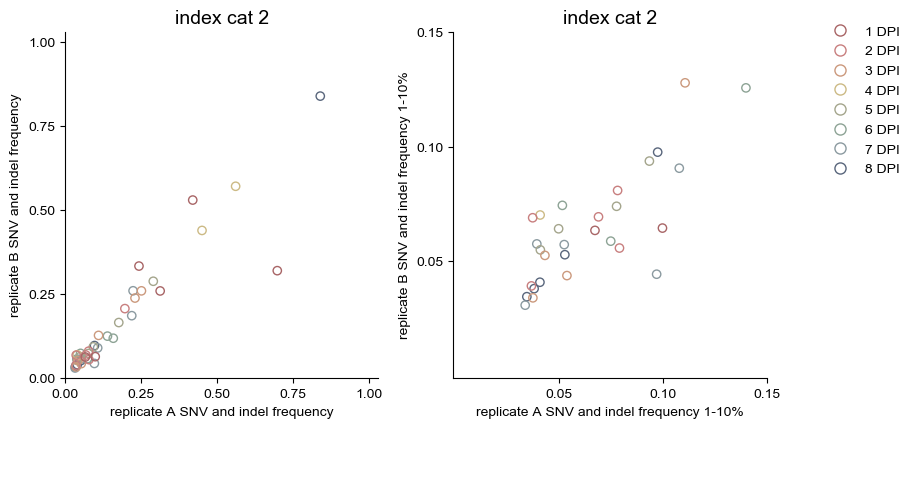

In [50]:
# generate a figure comparing SNV frequencies across replicates
fig1 = plt.figure(figsize=(8,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 8)

ax1 = fig1.add_subplot(gs[0,0:4]) # JT/TV plot
ax2 = fig1.add_subplot(gs[0,4:8]) # JT/TV plot ZOOM

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)

# replace NaNs with zeroes 
df2_1 = pd.read_csv("../data_derived/cleaned/2_1-intersection.csv", header=0, sep='\t')
df2_2 = pd.read_csv("../data_derived/cleaned/2_2-intersection.csv", header=0, sep='\t')
df2_3 = pd.read_csv("../data_derived/cleaned/2_3-intersection.csv", header=0, sep='\t')
df2_4 = pd.read_csv("../data_derived/cleaned/2_4-intersection.csv", header=0, sep='\t')
df2_5 = pd.read_csv("../data_derived/cleaned/2_5-intersection.csv", header=0, sep='\t')
df2_6 = pd.read_csv("../data_derived/cleaned/2_6-intersection.csv", header=0, sep='\t')
df2_7 = pd.read_csv("../data_derived/cleaned/2_7-intersection.csv", header=0, sep='\t')
df2_8 = pd.read_csv("../data_derived/cleaned/2_8-intersection.csv", header=0, sep='\t')
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# FOR PLOT replicate plot
ax1.scatter(df2_8.rep2_percent, df2_8.rep2_percent, edgecolor=colors8, facecolor='none')
ax2.scatter(df2_8.rep2_percent, df2_8.rep2_percent, edgecolor=colors8, facecolor='none')

ax1.scatter(df2_7.rep1_percent, df2_7.rep2_percent, edgecolor=colors7, facecolor='none')
ax2.scatter(df2_7.rep1_percent, df2_7.rep2_percent, edgecolor=colors7, facecolor='none')

ax1.scatter(df2_6.rep1_percent, df2_6.rep2_percent, edgecolor=colors6, facecolor='none')
ax2.scatter(df2_6.rep1_percent, df2_6.rep2_percent, edgecolor=colors6, facecolor='none')

ax1.scatter(df2_5.rep1_percent, df2_5.rep2_percent, edgecolor=colors5, facecolor='none')
ax2.scatter(df2_5.rep1_percent, df2_5.rep2_percent, edgecolor=colors5, facecolor='none')

ax1.scatter(df2_4.rep1_percent, df2_4.rep2_percent, edgecolor=colors4, facecolor='none')
ax2.scatter(df2_4.rep1_percent, df2_4.rep2_percent, edgecolor=colors4, facecolor='none')

ax1.scatter(df2_3.rep1_percent, df2_3.rep2_percent, edgecolor=colors3, facecolor='none')
ax2.scatter(df2_3.rep1_percent, df2_3.rep2_percent, edgecolor=colors3, facecolor='none')

ax1.scatter(df2_2.rep1_percent, df2_2.rep2_percent, edgecolor=colors2, facecolor='none')
ax2.scatter(df2_2.rep1_percent, df2_2.rep2_percent, edgecolor=colors2, facecolor='none')

ax1.scatter(df2_1.rep1_percent, df2_1.rep2_percent, edgecolor=colors1, facecolor='none')
ax2.scatter(df2_1.rep1_percent, df2_1.rep2_percent, edgecolor=colors1, facecolor='none')

# edit the axes - ax1
ax1.set_title('index cat 2', fontname='Arial', fontsize=14)
ax1.set_ylabel('replicate B SNV and indel frequency', fontname='Arial', fontsize=10)
ax1.set_xlabel('replicate A SNV and indel frequency', fontname='Arial', fontsize=10)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(0.001,1.03)
ax1.set_yticks([0, 0.25, 0.50, 0.75, 1.0])
ax1.set_xlim(0.001,1.03)
ax1.set_xticks([0, 0.25, 0.50, 0.75, 1.0])

# edit the axes - ax2
ax2.set_title('index cat 2', fontname='Arial', fontsize=14)
ax2.set_ylabel('replicate B SNV and indel frequency 1-10%', fontname='Arial', fontsize=10)
ax2.set_xlabel('replicate A SNV and indel frequency 1-10%', fontname='Arial', fontsize=10)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(-0.001, 0.15)
ax2.set_yticks([0.05, 0.1, 0.15])
ax2.set_xlim(-0.001, 0.15)
ax2.set_xticks([0.05, 0.1, 0.15])

# legend 
sample2_1 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors1, linestyle='None', markersize=8, label='1 DPI')
sample2_2 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors2, linestyle='None', markersize=8, label='2 DPI')
sample2_3 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors3, linestyle='None', markersize=8, label='3 DPI')
sample2_4 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors4, linestyle='None', markersize=8, label='4 DPI')
sample2_5 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors5, linestyle='None', markersize=8, label='5 DPI')
sample2_6 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors6, linestyle='None', markersize=8, label='6 DPI')
sample2_7 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors7, linestyle='None', markersize=8, label='7 DPI')
sample2_8 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors8, linestyle='None', markersize=8, label='8 DPI')

fig1.legend(handles=[sample2_1, sample2_2, sample2_3, sample2_4, sample2_5, sample2_6, sample2_7, sample2_8], frameon=False, fontsize=10, bbox_to_anchor=(1.14, 0.6))
   
# use tight_layout to optimize spacing of axes and titles within each subplot
fig1.tight_layout()
fig1.show()

# save this plot to the figures folder 
fig1.savefig("../figures/intersection_cat2.svg", bbox_inches='tight', dpi=300)

#

## cat 3

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


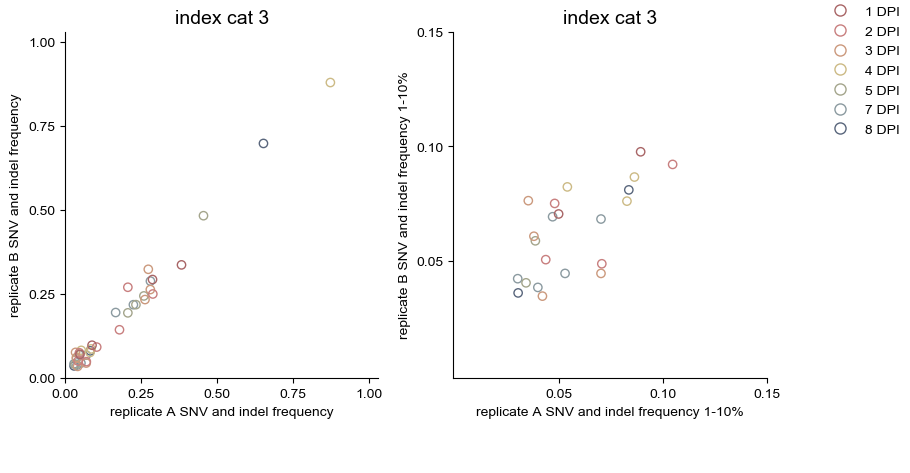

In [51]:
# generate a figure comparing SNV frequencies across replicates
fig1 = plt.figure(figsize=(8,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 8)

ax1 = fig1.add_subplot(gs[0,0:4]) # JT/TV plot
ax2 = fig1.add_subplot(gs[0,4:8]) # JT/TV plot ZOOM

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)

# replace NaNs with zeroes 
df3_1 = pd.read_csv("../data_derived/cleaned/3_1-intersection.csv", header=0, sep='\t')
df3_2 = pd.read_csv("../data_derived/cleaned/3_2-intersection.csv", header=0, sep='\t')
df3_3 = pd.read_csv("../data_derived/cleaned/3_3-intersection.csv", header=0, sep='\t')
df3_4 = pd.read_csv("../data_derived/cleaned/3_4-intersection.csv", header=0, sep='\t')
df3_5 = pd.read_csv("../data_derived/cleaned/3_5-intersection.csv", header=0, sep='\t')
# df3_6 = pd.read_csv("../data_derived/cleaned/3_6-intersection.csv", header=0, sep='\t')
df3_7 = pd.read_csv("../data_derived/cleaned/3_7-intersection.csv", header=0, sep='\t')
df3_8 = pd.read_csv("../data_derived/cleaned/3_8-intersection.csv", header=0, sep='\t')

# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# FOR PLOT replicate plot
ax1.scatter(df3_8.rep1_percent, df3_8.rep2_percent, edgecolor=colors8, facecolor='none')
ax2.scatter(df3_8.rep1_percent, df3_8.rep2_percent, edgecolor=colors8, facecolor='none')

ax1.scatter(df3_7.rep1_percent, df3_7.rep2_percent, edgecolor=colors7, facecolor='none')
ax2.scatter(df3_7.rep1_percent, df3_7.rep2_percent, edgecolor=colors7, facecolor='none')

# ax1.scatter(df3_6.rep1_percent, df3_6.rep2_percent, edgecolor=colors6, facecolor='none')
# ax2.scatter(df3_6.rep1_percent, df3_6.rep2_percent, edgecolor=colors6, facecolor='none')

ax1.scatter(df3_5.rep1_percent, df3_5.rep2_percent, edgecolor=colors5, facecolor='none')
ax2.scatter(df3_5.rep1_percent, df3_5.rep2_percent, edgecolor=colors5, facecolor='none')

ax1.scatter(df3_4.rep1_percent, df3_4.rep2_percent, edgecolor=colors4, facecolor='none')
ax2.scatter(df3_4.rep1_percent, df3_4.rep2_percent, edgecolor=colors4, facecolor='none')

ax1.scatter(df3_3.rep1_percent, df3_3.rep2_percent, edgecolor=colors3, facecolor='none')
ax2.scatter(df3_3.rep1_percent, df3_3.rep2_percent, edgecolor=colors3, facecolor='none')

ax1.scatter(df3_2.rep1_percent, df3_2.rep2_percent, edgecolor=colors2, facecolor='none')
ax2.scatter(df3_2.rep1_percent, df3_2.rep2_percent, edgecolor=colors2, facecolor='none')

ax1.scatter(df3_1.rep1_percent, df3_1.rep2_percent, edgecolor=colors1, facecolor='none')
ax2.scatter(df3_1.rep1_percent, df3_1.rep2_percent, edgecolor=colors1, facecolor='none')

# edit the axes - ax1
ax1.set_title('index cat 3', fontname='Arial', fontsize=14)
ax1.set_ylabel('replicate B SNV and indel frequency', fontname='Arial', fontsize=10)
ax1.set_xlabel('replicate A SNV and indel frequency', fontname='Arial', fontsize=10)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(0.001,1.03)
ax1.set_yticks([0, 0.25, 0.50, 0.75, 1.0])
ax1.set_xlim(0.001,1.03)
ax1.set_xticks([0, 0.25, 0.50, 0.75, 1.0])

# edit the axes - ax2
ax2.set_title('index cat 3', fontname='Arial', fontsize=14)
ax2.set_ylabel('replicate B SNV and indel frequency 1-10%', fontname='Arial', fontsize=10)
ax2.set_xlabel('replicate A SNV and indel frequency 1-10%', fontname='Arial', fontsize=10)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(-0.001, 0.15)
ax2.set_yticks([0.05, 0.1, 0.15])
ax2.set_xlim(-0.001, 0.15)
ax2.set_xticks([0.05, 0.1, 0.15])

# legend 
sample3_1 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors1, linestyle='None', markersize=8, label='1 DPI')
sample3_2 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors2, linestyle='None', markersize=8, label='2 DPI')
sample3_3 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors3, linestyle='None', markersize=8, label='3 DPI')
sample3_4 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors4, linestyle='None', markersize=8, label='4 DPI')
sample3_5 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors5, linestyle='None', markersize=8, label='5 DPI')
# sample3_6 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors6, linestyle='None', markersize=8, label='6 DPI')
sample3_7 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors7, linestyle='None', markersize=8, label='7 DPI')
sample3_8 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors8, linestyle='None', markersize=8, label='8 DPI')

fig1.legend(handles=[sample3_1, sample3_2, sample3_3, sample3_4, sample3_5, sample3_7, sample3_8], frameon=False, fontsize=10, bbox_to_anchor=(1.14, 0.6))
   
# use tight_layout to optimize spacing of axes and titles within each subplot
fig1.tight_layout()
fig1.show()

# save this plot to the figures folder 
fig1.savefig("../figures/intersection_cat3.svg", bbox_inches='tight', dpi=300)



# cat 4

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


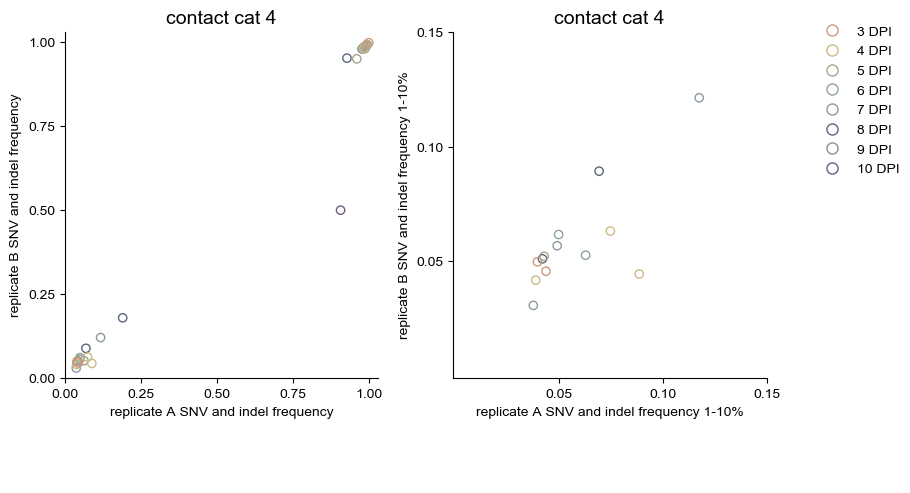

In [52]:
# generate a figure comparing SNV frequencies across replicates
fig1 = plt.figure(figsize=(8,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 8)

ax1 = fig1.add_subplot(gs[0,0:4]) # JT/TV plot
ax2 = fig1.add_subplot(gs[0,4:8]) # JT/TV plot ZOOM

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)

# replace NaNs with zeroes 

df4_3 = pd.read_csv("../data_derived/cleaned/4_3-intersection.csv", header=0, sep='\t')
df4_4 = pd.read_csv("../data_derived/cleaned/4_4-intersection.csv", header=0, sep='\t')
df4_5 = pd.read_csv("../data_derived/cleaned/4_5-intersection.csv", header=0, sep='\t')
df4_6 = pd.read_csv("../data_derived/cleaned/4_6-intersection.csv", header=0, sep='\t')
df4_7 = pd.read_csv("../data_derived/cleaned/4_7-intersection.csv", header=0, sep='\t')
df4_8 = pd.read_csv("../data_derived/cleaned/4_8-intersection.csv", header=0, sep='\t')
df4_9 = pd.read_csv("../data_derived/cleaned/4_9-intersection.csv", header=0, sep='\t')
df4_10 = pd.read_csv("../data_derived/cleaned/4_10-intersection.csv", header=0, sep='\t')

# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# FOR PLOT replicate plot
ax1.scatter(df4_10.rep1_percent, df4_10.rep2_percent, edgecolor=colors10, facecolor='none')
ax2.scatter(df4_10.rep1_percent, df4_10.rep2_percent, edgecolor=colors10, facecolor='none')

ax1.scatter(df4_9.rep1_percent, df4_9.rep2_percent, edgecolor=colors9, facecolor='none')
ax2.scatter(df4_9.rep1_percent, df4_9.rep2_percent, edgecolor=colors9, facecolor='none')

ax1.scatter(df4_8.rep1_percent, df4_8.rep2_percent, edgecolor=colors8, facecolor='none')
ax2.scatter(df4_8.rep1_percent, df4_8.rep2_percent, edgecolor=colors8, facecolor='none')

ax1.scatter(df4_7.rep1_percent, df4_7.rep2_percent, edgecolor=colors7, facecolor='none')
ax2.scatter(df4_7.rep1_percent, df4_7.rep2_percent, edgecolor=colors7, facecolor='none')

ax1.scatter(df4_6.rep1_percent, df4_6.rep2_percent, edgecolor=colors6, facecolor='none')
ax2.scatter(df4_6.rep1_percent, df4_6.rep2_percent, edgecolor=colors6, facecolor='none')

ax1.scatter(df4_5.rep1_percent, df4_5.rep2_percent, edgecolor=colors5, facecolor='none')
ax2.scatter(df4_5.rep1_percent, df4_5.rep2_percent, edgecolor=colors5, facecolor='none')

ax1.scatter(df4_4.rep1_percent, df4_4.rep2_percent, edgecolor=colors4, facecolor='none')
ax2.scatter(df4_4.rep1_percent, df4_4.rep2_percent, edgecolor=colors4, facecolor='none')

ax1.scatter(df4_3.rep1_percent, df4_3.rep2_percent, edgecolor=colors3, facecolor='none')
ax2.scatter(df4_3.rep1_percent, df4_3.rep2_percent, edgecolor=colors3, facecolor='none')


# edit the axes - ax1
ax1.set_title('contact cat 4', fontname='Arial', fontsize=14)
ax1.set_ylabel('replicate B SNV and indel frequency', fontname='Arial', fontsize=10)
ax1.set_xlabel('replicate A SNV and indel frequency', fontname='Arial', fontsize=10)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(0.001,1.03)
ax1.set_yticks([0, 0.25, 0.50, 0.75, 1.0])
ax1.set_xlim(0.001,1.03)
ax1.set_xticks([0, 0.25, 0.50, 0.75, 1.0])

# edit the axes - ax2
ax2.set_title('contact cat 4', fontname='Arial', fontsize=14)
ax2.set_ylabel('replicate B SNV and indel frequency 1-10%', fontname='Arial', fontsize=10)
ax2.set_xlabel('replicate A SNV and indel frequency 1-10%', fontname='Arial', fontsize=10)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(-0.001, 0.15)
ax2.set_yticks([0.05, 0.1, 0.15])
ax2.set_xlim(-0.001, 0.15)
ax2.set_xticks([0.05, 0.1, 0.15])

# legend 
sample4_3 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors3, linestyle='None', markersize=8, label='3 DPI')
sample4_4 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors4, linestyle='None', markersize=8, label='4 DPI')
sample4_5 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors5, linestyle='None', markersize=8, label='5 DPI')
sample4_6 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors6, linestyle='None', markersize=8, label='6 DPI')
sample4_7 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors7, linestyle='None', markersize=8, label='7 DPI')
sample4_8 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors8, linestyle='None', markersize=8, label='8 DPI')
sample4_9 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors9, linestyle='None', markersize=8, label='9 DPI')
sample4_10 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors10, linestyle='None', markersize=8, label='10 DPI')

fig1.legend(handles=[sample4_3, sample4_4, sample4_5, sample4_6, sample4_7, sample4_8, sample4_9, sample4_10], frameon=False, fontsize=10, bbox_to_anchor=(1.14, 0.6))
   
# use tight_layout to optimize spacing of axes and titles within each subplot
fig1.tight_layout()
fig1.show()

# save this plot to the figures folder 
fig1.savefig("../figures/intersection_cat4.svg", bbox_inches='tight', dpi=300)


# cat 5

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


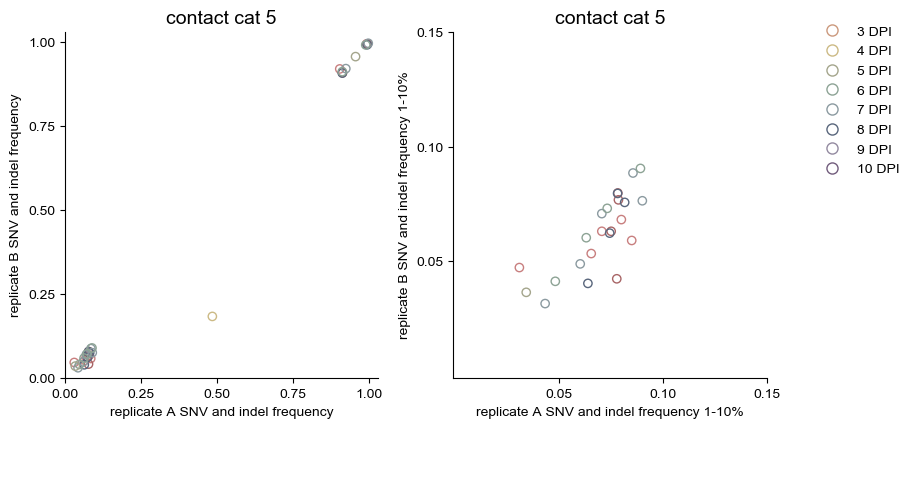

In [53]:
# generate a figure comparing SNV frequencies across replicates
fig1 = plt.figure(figsize=(8,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 8)

ax1 = fig1.add_subplot(gs[0,0:4]) # JT/TV plot
ax2 = fig1.add_subplot(gs[0,4:8]) # JT/TV plot ZOOM

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)

# replace NaNs with zeroes 

df5_3 = pd.read_csv("../data_derived/cleaned/5_3-intersection.csv", header=0, sep='\t')
df5_4 = pd.read_csv("../data_derived/cleaned/5_4-intersection.csv", header=0, sep='\t')
df5_5 = pd.read_csv("../data_derived/cleaned/5_5-intersection.csv", header=0, sep='\t')
df5_6 = pd.read_csv("../data_derived/cleaned/5_6-intersection.csv", header=0, sep='\t')
df5_7 = pd.read_csv("../data_derived/cleaned/5_7-intersection.csv", header=0, sep='\t')
df5_8 = pd.read_csv("../data_derived/cleaned/5_8-intersection.csv", header=0, sep='\t')
df5_9 = pd.read_csv("../data_derived/cleaned/5_9-intersection.csv", header=0, sep='\t')
df5_10 = pd.read_csv("../data_derived/cleaned/5_10-intersection.csv", header=0, sep='\t')
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# FOR PLOT replicate plot
ax1.scatter(df5_10.rep1_percent, df5_10.rep2_percent, edgecolor=colors2, facecolor='none')
ax2.scatter(df5_10.rep1_percent, df5_10.rep2_percent, edgecolor=colors2, facecolor='none')

ax1.scatter(df5_9.rep1_percent, df5_9.rep2_percent, edgecolor=colors1, facecolor='none')
ax2.scatter(df5_9.rep1_percent, df5_9.rep2_percent, edgecolor=colors1, facecolor='none')

ax1.scatter(df5_8.rep1_percent, df5_8.rep2_percent, edgecolor=colors8, facecolor='none')
ax2.scatter(df5_8.rep1_percent, df5_8.rep2_percent, edgecolor=colors8, facecolor='none')

ax1.scatter(df5_7.rep1_percent, df5_7.rep2_percent, edgecolor=colors7, facecolor='none')
ax2.scatter(df5_7.rep1_percent, df5_7.rep2_percent, edgecolor=colors7, facecolor='none')

ax1.scatter(df5_6.rep1_percent, df5_6.rep2_percent, edgecolor=colors6, facecolor='none')
ax2.scatter(df5_6.rep1_percent, df5_6.rep2_percent, edgecolor=colors6, facecolor='none')

ax1.scatter(df5_5.rep1_percent, df5_5.rep2_percent, edgecolor=colors5, facecolor='none')
ax2.scatter(df5_5.rep1_percent, df5_5.rep2_percent, edgecolor=colors5, facecolor='none')

ax1.scatter(df5_4.rep1_percent, df5_4.rep2_percent, edgecolor=colors4, facecolor='none')
ax2.scatter(df5_4.rep1_percent, df5_4.rep2_percent, edgecolor=colors4, facecolor='none')

ax1.scatter(df5_3.rep1_percent, df5_3.rep2_percent, edgecolor=colors3, facecolor='none')
ax2.scatter(df5_3.rep1_percent, df5_3.rep2_percent, edgecolor=colors3, facecolor='none')

# edit the axes - ax1
ax1.set_title('contact cat 5', fontname='Arial', fontsize=14)
ax1.set_ylabel('replicate B SNV and indel frequency', fontname='Arial', fontsize=10)
ax1.set_xlabel('replicate A SNV and indel frequency', fontname='Arial', fontsize=10)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(0.001,1.03)
ax1.set_yticks([0, 0.25, 0.50, 0.75, 1.0])
ax1.set_xlim(0.001,1.03)
ax1.set_xticks([0, 0.25, 0.50, 0.75, 1.0])

# edit the axes - ax2
ax2.set_title('contact cat 5', fontname='Arial', fontsize=14)
ax2.set_ylabel('replicate B SNV and indel frequency 1-10%', fontname='Arial', fontsize=10)
ax2.set_xlabel('replicate A SNV and indel frequency 1-10%', fontname='Arial', fontsize=10)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(-0.001, 0.15)
ax2.set_yticks([0.05, 0.1, 0.15])
ax2.set_xlim(-0.001, 0.15)
ax2.set_xticks([0.05, 0.1, 0.15])

# legend 
sample5_3 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors3, linestyle='None', markersize=8, label='3 DPI')
sample5_4 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors4, linestyle='None', markersize=8, label='4 DPI')
sample5_5 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors5, linestyle='None', markersize=8, label='5 DPI')
sample5_6 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors6, linestyle='None', markersize=8, label='6 DPI')
sample5_7 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors7, linestyle='None', markersize=8, label='7 DPI')
sample5_8 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors8, linestyle='None', markersize=8, label='8 DPI')
sample5_9 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors9, linestyle='None', markersize=8, label='9 DPI')
sample5_10 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors10, linestyle='None', markersize=8, label='10 DPI')

fig1.legend(handles=[sample5_3, sample5_4, sample5_5, sample5_6, sample5_7, sample5_8, sample5_9, sample5_10], frameon=False, fontsize=10, bbox_to_anchor=(1.14, 0.6))
   
# use tight_layout to optimize spacing of axes and titles within each subplot
fig1.tight_layout()
fig1.show()

# save this plot to the figures folder 
fig1.savefig("../figures/intersection_cat5.svg", bbox_inches='tight', dpi=300)

# cat 6

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


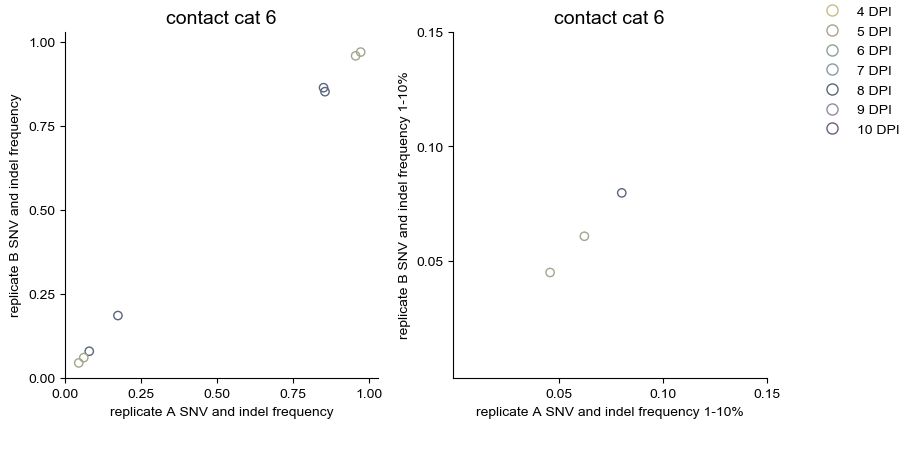

In [54]:
# generate a figure comparing SNV frequencies across replicates
fig1 = plt.figure(figsize=(8,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 8)

ax1 = fig1.add_subplot(gs[0,0:4]) # JT/TV plot
ax2 = fig1.add_subplot(gs[0,4:8]) # JT/TV plot ZOOM

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)

# replace NaNs with zeroes 
# df6_3 = pd.read_csv("../data_derived/cleaned/6_3-intersection.csv", header=0, sep='\t')
df6_4 = pd.read_csv("../data_derived/cleaned/6_4-intersection.csv", header=0, sep='\t')
df6_5 = pd.read_csv("../data_derived/cleaned/6_5-intersection.csv", header=0, sep='\t')
df6_6 = pd.read_csv("../data_derived/cleaned/6_6-intersection.csv", header=0, sep='\t')
df6_7 = pd.read_csv("../data_derived/cleaned/6_7-intersection.csv", header=0, sep='\t')
df6_8 = pd.read_csv("../data_derived/cleaned/6_8-intersection.csv", header=0, sep='\t')
df6_9 = pd.read_csv("../data_derived/cleaned/6_9-intersection.csv", header=0, sep='\t')
df6_10 = pd.read_csv("../data_derived/cleaned/6_10-intersection.csv", header=0, sep='\t')
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# FOR PLOT replicate plot
ax1.scatter(df6_10.rep1_percent, df6_10.rep2_percent, edgecolor=colors2, facecolor='none')
ax2.scatter(df6_10.rep1_percent, df6_10.rep2_percent, edgecolor=colors2, facecolor='none')

ax1.scatter(df6_9.rep1_percent, df6_9.rep2_percent, edgecolor=colors9, facecolor='none')
ax2.scatter(df6_9.rep1_percent, df6_9.rep2_percent, edgecolor=colors9, facecolor='none')

ax1.scatter(df6_8.rep1_percent, df6_8.rep2_percent, edgecolor=colors8, facecolor='none')
ax2.scatter(df6_8.rep1_percent, df6_8.rep2_percent, edgecolor=colors8, facecolor='none')

ax1.scatter(df6_7.rep1_percent, df6_7.rep2_percent, edgecolor=colors7, facecolor='none')
ax2.scatter(df6_7.rep1_percent, df6_7.rep2_percent, edgecolor=colors7, facecolor='none')

ax1.scatter(df6_6.rep1_percent, df6_6.rep2_percent, edgecolor=colors6, facecolor='none')
ax2.scatter(df6_6.rep1_percent, df6_6.rep2_percent, edgecolor=colors6, facecolor='none')

ax1.scatter(df6_5.rep1_percent, df6_5.rep2_percent, edgecolor=colors5, facecolor='none')
ax2.scatter(df6_5.rep1_percent, df6_5.rep2_percent, edgecolor=colors5, facecolor='none')

ax1.scatter(df6_4.rep1_percent, df6_4.rep2_percent, edgecolor=colors4, facecolor='none')
ax2.scatter(df6_4.rep1_percent, df6_4.rep2_percent, edgecolor=colors4, facecolor='none')

# ax1.scatter(df6_3.rep1_percent, df6_3.rep2_percent, edgecolor=colors3, facecolor='none')
# ax2.scatter(df6_3.rep1_percent, df6_3.rep2_percent, edgecolor=colors3, facecolor='none')

# edit the axes - ax1
ax1.set_title('contact cat 6', fontname='Arial', fontsize=14)
ax1.set_ylabel('replicate B SNV and indel frequency', fontname='Arial', fontsize=10)
ax1.set_xlabel('replicate A SNV and indel frequency', fontname='Arial', fontsize=10)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(0.001,1.03)
ax1.set_yticks([0, 0.25, 0.50, 0.75, 1.0])
ax1.set_xlim(0.001,1.03)
ax1.set_xticks([0, 0.25, 0.50, 0.75, 1.0])

# edit the axes - ax2
ax2.set_title('contact cat 6', fontname='Arial', fontsize=14)
ax2.set_ylabel('replicate B SNV and indel frequency 1-10%', fontname='Arial', fontsize=10)
ax2.set_xlabel('replicate A SNV and indel frequency 1-10%', fontname='Arial', fontsize=10)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(-0.001, 0.15)
ax2.set_yticks([0.05, 0.1, 0.15])
ax2.set_xlim(-0.001, 0.15)
ax2.set_xticks([0.05, 0.1, 0.15])

# legend 
# sample6_3 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors3, linestyle='None', markersize=8, label='3 DPI')
sample6_4 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors4, linestyle='None', markersize=8, label='4 DPI')
sample6_5 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors5, linestyle='None', markersize=8, label='5 DPI')
sample6_6 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors6, linestyle='None', markersize=8, label='6 DPI')
sample6_7 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors7, linestyle='None', markersize=8, label='7 DPI')
sample6_8 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors8, linestyle='None', markersize=8, label='8 DPI')
sample6_9 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors9, linestyle='None', markersize=8, label='9 DPI')
sample6_10 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors10, linestyle='None', markersize=8, label='10 DPI')

fig1.legend(handles=[sample6_4, sample6_5, sample6_6, sample6_7, sample6_8, sample6_9, sample6_10], frameon=False, fontsize=10, bbox_to_anchor=(1.14, 0.6))
   
# use tight_layout to optimize spacing of axes and titles within each subplot
fig1.tight_layout()
fig1.show()

# save this plot to the figures folder 
fig1.savefig("../figures/intersection_cat6.svg", bbox_inches='tight', dpi=300)

# plot all index cats together (intersection plots) 

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


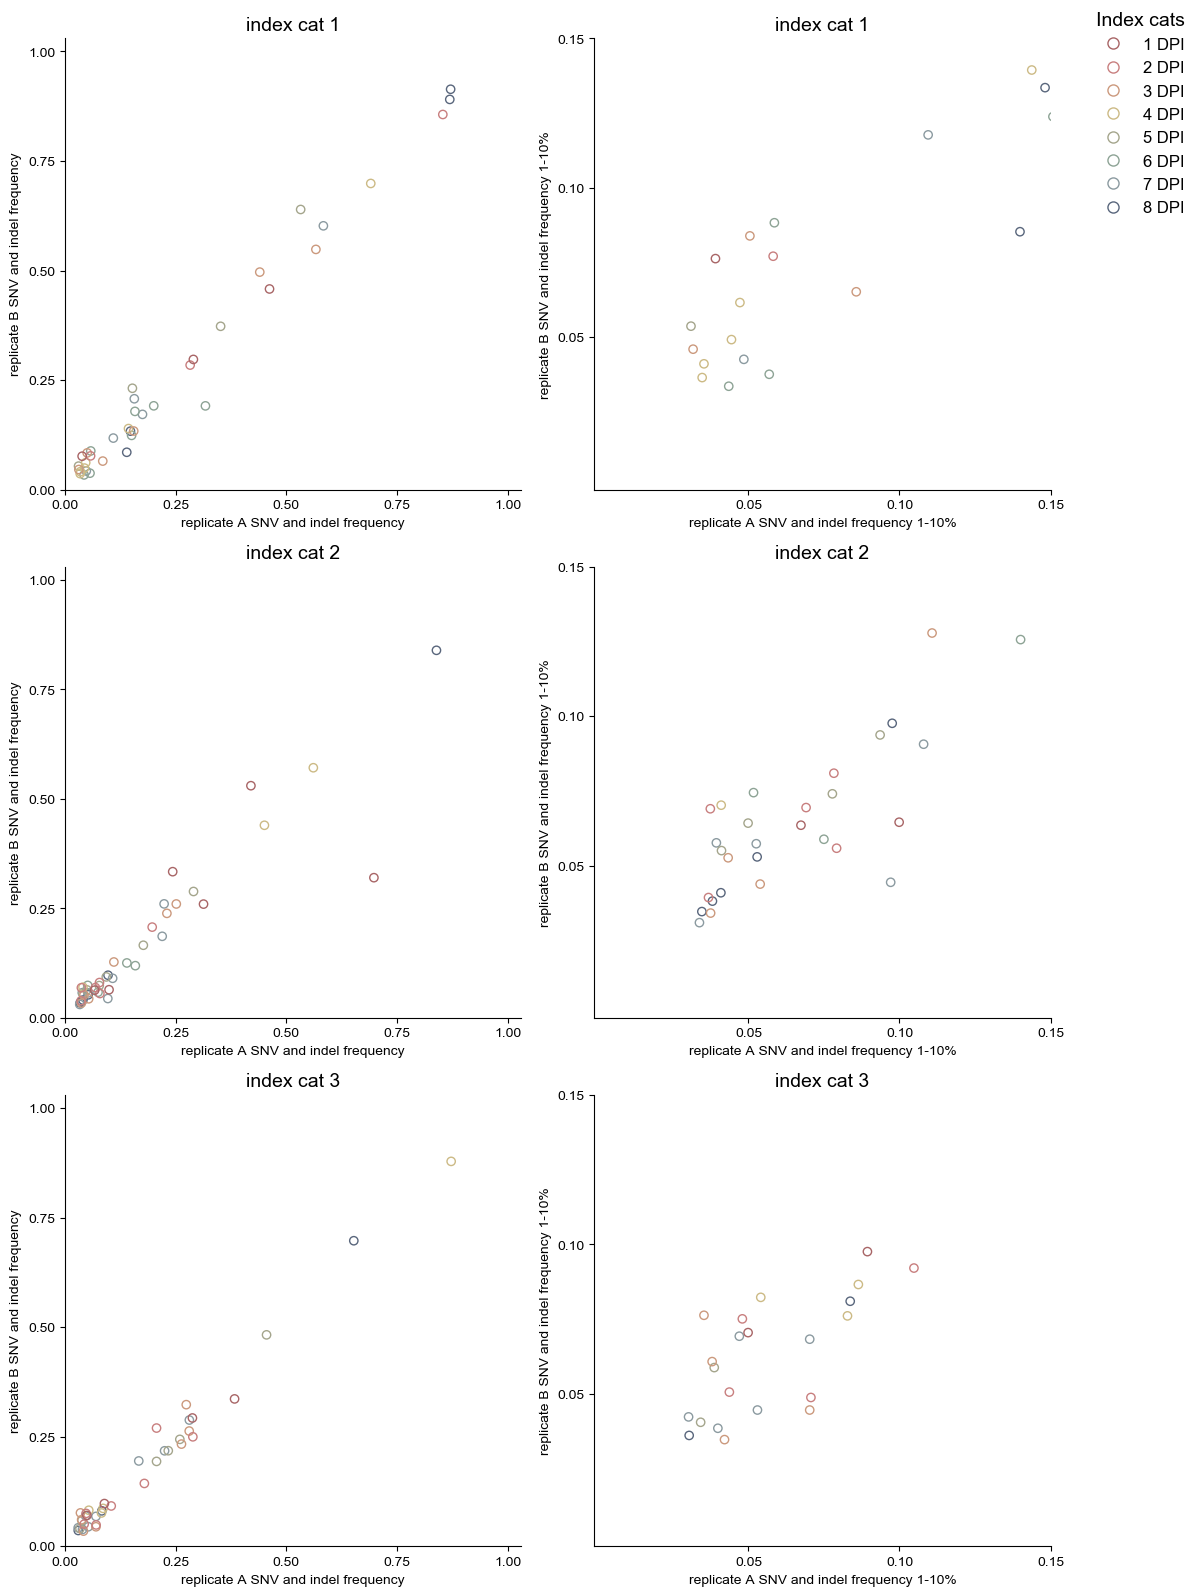

In [55]:
fig1 = plt.figure(figsize=(16,16), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(3, 12)

ax1 = fig1.add_subplot(gs[0,0:4]) # JT/TV plot - Cat 1
ax2 = fig1.add_subplot(gs[0,4:8]) # JT/TV plot ZOOM - Cat 1

ax3 = fig1.add_subplot(gs[1,0:4]) # JT/TV plot - Cat 2
ax4 = fig1.add_subplot(gs[1,4:8]) # JT/TV plot ZOOM - Cat 2

ax5 = fig1.add_subplot(gs[2,0:4]) # JT/TV plot - Cat 3
ax6 = fig1.add_subplot(gs[2,4:8]) # JT/TV plot ZOOM - Cat 3

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(True)
ax3.spines['left'].set_visible(True)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_visible(True)
ax4.spines['left'].set_visible(True)

ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(True)
ax5.spines['left'].set_visible(True)
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.spines['bottom'].set_visible(True)
ax6.spines['left'].set_visible(True)

# load DFs
df1_1 = pd.read_csv("../data_derived/cleaned/1_1-intersection.csv", header=0, sep='\t')
df1_2 = pd.read_csv("../data_derived/cleaned/1_2-intersection.csv", header=0, sep='\t')
df1_3 = pd.read_csv("../data_derived/cleaned/1_3-intersection.csv", header=0, sep='\t')
df1_4 = pd.read_csv("../data_derived/cleaned/1_4-intersection.csv", header=0, sep='\t')
df1_5 = pd.read_csv("../data_derived/cleaned/1_5-intersection.csv", header=0, sep='\t')
df1_6 = pd.read_csv("../data_derived/cleaned/1_6-intersection.csv", header=0, sep='\t')
df1_7 = pd.read_csv("../data_derived/cleaned/1_7-intersection.csv", header=0, sep='\t')
df1_8 = pd.read_csv("../data_derived/cleaned/1_8-intersection.csv", header=0, sep='\t')

df2_1 = pd.read_csv("../data_derived/cleaned/2_1-intersection.csv", header=0, sep='\t')
df2_2 = pd.read_csv("../data_derived/cleaned/2_2-intersection.csv", header=0, sep='\t')
df2_3 = pd.read_csv("../data_derived/cleaned/2_3-intersection.csv", header=0, sep='\t')
df2_4 = pd.read_csv("../data_derived/cleaned/2_4-intersection.csv", header=0, sep='\t')
df2_5 = pd.read_csv("../data_derived/cleaned/2_5-intersection.csv", header=0, sep='\t')
df2_6 = pd.read_csv("../data_derived/cleaned/2_6-intersection.csv", header=0, sep='\t')
df2_7 = pd.read_csv("../data_derived/cleaned/2_7-intersection.csv", header=0, sep='\t')
df2_8 = pd.read_csv("../data_derived/cleaned/2_8-intersection.csv", header=0, sep='\t')

df3_1 = pd.read_csv("../data_derived/cleaned/3_1-intersection.csv", header=0, sep='\t')
df3_2 = pd.read_csv("../data_derived/cleaned/3_2-intersection.csv", header=0, sep='\t')
df3_3 = pd.read_csv("../data_derived/cleaned/3_3-intersection.csv", header=0, sep='\t')
df3_4 = pd.read_csv("../data_derived/cleaned/3_4-intersection.csv", header=0, sep='\t')
df3_5 = pd.read_csv("../data_derived/cleaned/3_5-intersection.csv", header=0, sep='\t')
# df3_6 = pd.read_csv("../data_derived/cleaned/3_6-intersection.csv", header=0, sep='\t')
df3_7 = pd.read_csv("../data_derived/cleaned/3_7-intersection.csv", header=0, sep='\t')
df3_8 = pd.read_csv("../data_derived/cleaned/3_8-intersection.csv", header=0, sep='\t')

# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

ax3.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax3.tick_params(axis = 'both', which = 'minor', labelsize = 10)
ax4.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax4.tick_params(axis = 'both', which = 'minor', labelsize = 10)

ax5.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax5.tick_params(axis = 'both', which = 'minor', labelsize = 10)
ax6.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax6.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# FOR PLOT replicate plot
ax1.scatter(df1_8.rep1_percent, df1_8.rep2_percent, edgecolor=colors8, facecolor='none')
ax2.scatter(df1_8.rep1_percent, df1_8.rep2_percent, edgecolor=colors8, facecolor='none')

ax1.scatter(df1_7.rep1_percent, df1_7.rep2_percent, edgecolor=colors7, facecolor='none')
ax2.scatter(df1_7.rep1_percent, df1_7.rep2_percent, edgecolor=colors7, facecolor='none')

ax1.scatter(df1_6.rep1_percent, df1_6.rep2_percent, edgecolor=colors6, facecolor='none')
ax2.scatter(df1_6.rep1_percent, df1_6.rep2_percent, edgecolor=colors6, facecolor='none')

ax1.scatter(df1_5.rep1_percent, df1_5.rep2_percent, edgecolor=colors5, facecolor='none')
ax2.scatter(df1_5.rep1_percent, df1_5.rep2_percent, edgecolor=colors5, facecolor='none')

ax1.scatter(df1_4.rep1_percent, df1_4.rep2_percent, edgecolor=colors4, facecolor='none')
ax2.scatter(df1_4.rep1_percent, df1_4.rep2_percent, edgecolor=colors4, facecolor='none')

ax1.scatter(df1_3.rep1_percent, df1_3.rep2_percent, edgecolor=colors3, facecolor='none')
ax2.scatter(df1_3.rep1_percent, df1_3.rep2_percent, edgecolor=colors3, facecolor='none')

ax1.scatter(df1_2.rep1_percent, df1_2.rep2_percent, edgecolor=colors2, facecolor='none')
ax2.scatter(df1_2.rep1_percent, df1_2.rep2_percent, edgecolor=colors2, facecolor='none')

ax1.scatter(df1_1.rep1_percent, df1_1.rep2_percent, edgecolor=colors1, facecolor='none')
ax2.scatter(df1_1.rep1_percent, df1_1.rep2_percent, edgecolor=colors1, facecolor='none')

ax3.scatter(df2_8.rep2_percent, df2_8.rep2_percent, edgecolor=colors8, facecolor='none')
ax4.scatter(df2_8.rep2_percent, df2_8.rep2_percent, edgecolor=colors8, facecolor='none')

ax3.scatter(df2_7.rep1_percent, df2_7.rep2_percent, edgecolor=colors7, facecolor='none')
ax4.scatter(df2_7.rep1_percent, df2_7.rep2_percent, edgecolor=colors7, facecolor='none')

ax3.scatter(df2_6.rep1_percent, df2_6.rep2_percent, edgecolor=colors6, facecolor='none')
ax4.scatter(df2_6.rep1_percent, df2_6.rep2_percent, edgecolor=colors6, facecolor='none')

ax3.scatter(df2_5.rep1_percent, df2_5.rep2_percent, edgecolor=colors5, facecolor='none')
ax4.scatter(df2_5.rep1_percent, df2_5.rep2_percent, edgecolor=colors5, facecolor='none')

ax3.scatter(df2_4.rep1_percent, df2_4.rep2_percent, edgecolor=colors4, facecolor='none')
ax4.scatter(df2_4.rep1_percent, df2_4.rep2_percent, edgecolor=colors4, facecolor='none')

ax3.scatter(df2_3.rep1_percent, df2_3.rep2_percent, edgecolor=colors3, facecolor='none')
ax4.scatter(df2_3.rep1_percent, df2_3.rep2_percent, edgecolor=colors3, facecolor='none')

ax3.scatter(df2_2.rep1_percent, df2_2.rep2_percent, edgecolor=colors2, facecolor='none')
ax4.scatter(df2_2.rep1_percent, df2_2.rep2_percent, edgecolor=colors2, facecolor='none')

ax3.scatter(df2_1.rep1_percent, df2_1.rep2_percent, edgecolor=colors1, facecolor='none')
ax4.scatter(df2_1.rep1_percent, df2_1.rep2_percent, edgecolor=colors1, facecolor='none')

ax5.scatter(df3_8.rep1_percent, df3_8.rep2_percent, edgecolor=colors8, facecolor='none')
ax6.scatter(df3_8.rep1_percent, df3_8.rep2_percent, edgecolor=colors8, facecolor='none')

ax5.scatter(df3_7.rep1_percent, df3_7.rep2_percent, edgecolor=colors7, facecolor='none')
ax6.scatter(df3_7.rep1_percent, df3_7.rep2_percent, edgecolor=colors7, facecolor='none')

# ax5.scatter(df3_6.rep1_percent, df3_6.rep2_percent, edgecolor=colors6, facecolor='none')
# ax6.scatter(df3_6.rep1_percent, df3_6.rep2_percent, edgecolor=colors6, facecolor='none')

ax5.scatter(df3_5.rep1_percent, df3_5.rep2_percent, edgecolor=colors5, facecolor='none')
ax6.scatter(df3_5.rep1_percent, df3_5.rep2_percent, edgecolor=colors5, facecolor='none')

ax5.scatter(df3_4.rep1_percent, df3_4.rep2_percent, edgecolor=colors4, facecolor='none')
ax6.scatter(df3_4.rep1_percent, df3_4.rep2_percent, edgecolor=colors4, facecolor='none')

ax5.scatter(df3_3.rep1_percent, df3_3.rep2_percent, edgecolor=colors3, facecolor='none')
ax6.scatter(df3_3.rep1_percent, df3_3.rep2_percent, edgecolor=colors3, facecolor='none')

ax5.scatter(df3_2.rep1_percent, df3_2.rep2_percent, edgecolor=colors2, facecolor='none')
ax6.scatter(df3_2.rep1_percent, df3_2.rep2_percent, edgecolor=colors2, facecolor='none')

ax5.scatter(df3_1.rep1_percent, df3_1.rep2_percent, edgecolor=colors1, facecolor='none')
ax6.scatter(df3_1.rep1_percent, df3_1.rep2_percent, edgecolor=colors1, facecolor='none')


# edit the axes - ax1
ax1.set_title('index cat 1', fontname='Arial', fontsize=14)
ax1.set_ylabel('replicate B SNV and indel frequency', fontname='Arial', fontsize=10)
ax1.set_xlabel('replicate A SNV and indel frequency', fontname='Arial', fontsize=10)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(0.001,1.03)
ax1.set_yticks([0, 0.25, 0.50, 0.75, 1.0])
ax1.set_xlim(0.001,1.03)
ax1.set_xticks([0, 0.25, 0.50, 0.75, 1.0])

ax3.set_title('index cat 2', fontname='Arial', fontsize=14)
ax3.set_ylabel('replicate B SNV and indel frequency', fontname='Arial', fontsize=10)
ax3.set_xlabel('replicate A SNV and indel frequency', fontname='Arial', fontsize=10)
ax3.set_facecolor('white')
for tick in ax3.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax3.get_yticklabels():
    tick.set_fontname("Arial")
ax3.set_ylim(0.001,1.03)
ax3.set_yticks([0, 0.25, 0.50, 0.75, 1.0])
ax3.set_xlim(0.001,1.03)
ax3.set_xticks([0, 0.25, 0.50, 0.75, 1.0])

ax5.set_title('index cat 3', fontname='Arial', fontsize=14)
ax5.set_ylabel('replicate B SNV and indel frequency', fontname='Arial', fontsize=10)
ax5.set_xlabel('replicate A SNV and indel frequency', fontname='Arial', fontsize=10)
ax5.set_facecolor('white')
for tick in ax5.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax5.get_yticklabels():
    tick.set_fontname("Arial")
ax5.set_ylim(0.001,1.03)
ax5.set_yticks([0, 0.25, 0.50, 0.75, 1.0])
ax5.set_xlim(0.001,1.03)
ax5.set_xticks([0, 0.25, 0.50, 0.75, 1.0])

# edit the axes - ax2
ax2.set_title('index cat 1', fontname='Arial', fontsize=14)
ax2.set_ylabel('replicate B SNV and indel frequency 1-10%', fontname='Arial', fontsize=10)
ax2.set_xlabel('replicate A SNV and indel frequency 1-10%', fontname='Arial', fontsize=10)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(-0.001, 0.15)
ax2.set_yticks([0.05, 0.1, 0.15])
ax2.set_xlim(-0.001, 0.15)
ax2.set_xticks([0.05, 0.1, 0.15])

ax4.set_title('index cat 2', fontname='Arial', fontsize=14)
ax4.set_ylabel('replicate B SNV and indel frequency 1-10%', fontname='Arial', fontsize=10)
ax4.set_xlabel('replicate A SNV and indel frequency 1-10%', fontname='Arial', fontsize=10)
ax4.set_facecolor('white')
for tick in ax4.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax4.get_yticklabels():
    tick.set_fontname("Arial")
ax4.set_ylim(-0.001, 0.15)
ax4.set_yticks([0.05, 0.1, 0.15])
ax4.set_xlim(-0.001, 0.15)
ax4.set_xticks([0.05, 0.1, 0.15])

ax6.set_title('index cat 3', fontname='Arial', fontsize=14)
ax6.set_ylabel('replicate B SNV and indel frequency 1-10%', fontname='Arial', fontsize=10)
ax6.set_xlabel('replicate A SNV and indel frequency 1-10%', fontname='Arial', fontsize=10)
ax6.set_facecolor('white')
for tick in ax6.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax6.get_yticklabels():
    tick.set_fontname("Arial")
ax6.set_ylim(-0.001, 0.15)
ax6.set_yticks([0.05, 0.1, 0.15])
ax6.set_xlim(-0.001, 0.15)
ax6.set_xticks([0.05, 0.1, 0.15])

# legend 
sample1_1 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors1, linestyle='None', markersize=8, label='1 DPI')
sample1_2 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors2, linestyle='None', markersize=8, label='2 DPI')
sample1_3 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors3, linestyle='None', markersize=8, label='3 DPI')
sample1_4 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors4, linestyle='None', markersize=8, label='4 DPI')
sample1_5 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors5, linestyle='None', markersize=8, label='5 DPI')
sample1_6 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors6, linestyle='None', markersize=8, label='6 DPI')
sample1_7 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors7, linestyle='None', markersize=8, label='7 DPI')
sample1_8 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors8, linestyle='None', markersize=8, label='8 DPI')

fig1.legend(title='Index cats',title_fontsize=14,handles=[sample1_1, sample1_2, sample1_3, sample1_4, sample1_5, sample1_6, sample1_7, sample1_8], frameon=False, fontsize=12, bbox_to_anchor=(.75, 1))
   
# use tight_layout to optimize spacing of axes and titles within each subplot
fig1.tight_layout()
fig1.show()
fig1.savefig("../figures/intersection_index_cats.svg", bbox_inches='tight', dpi=300)

# plot all contact cats together (intersection plots) 

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


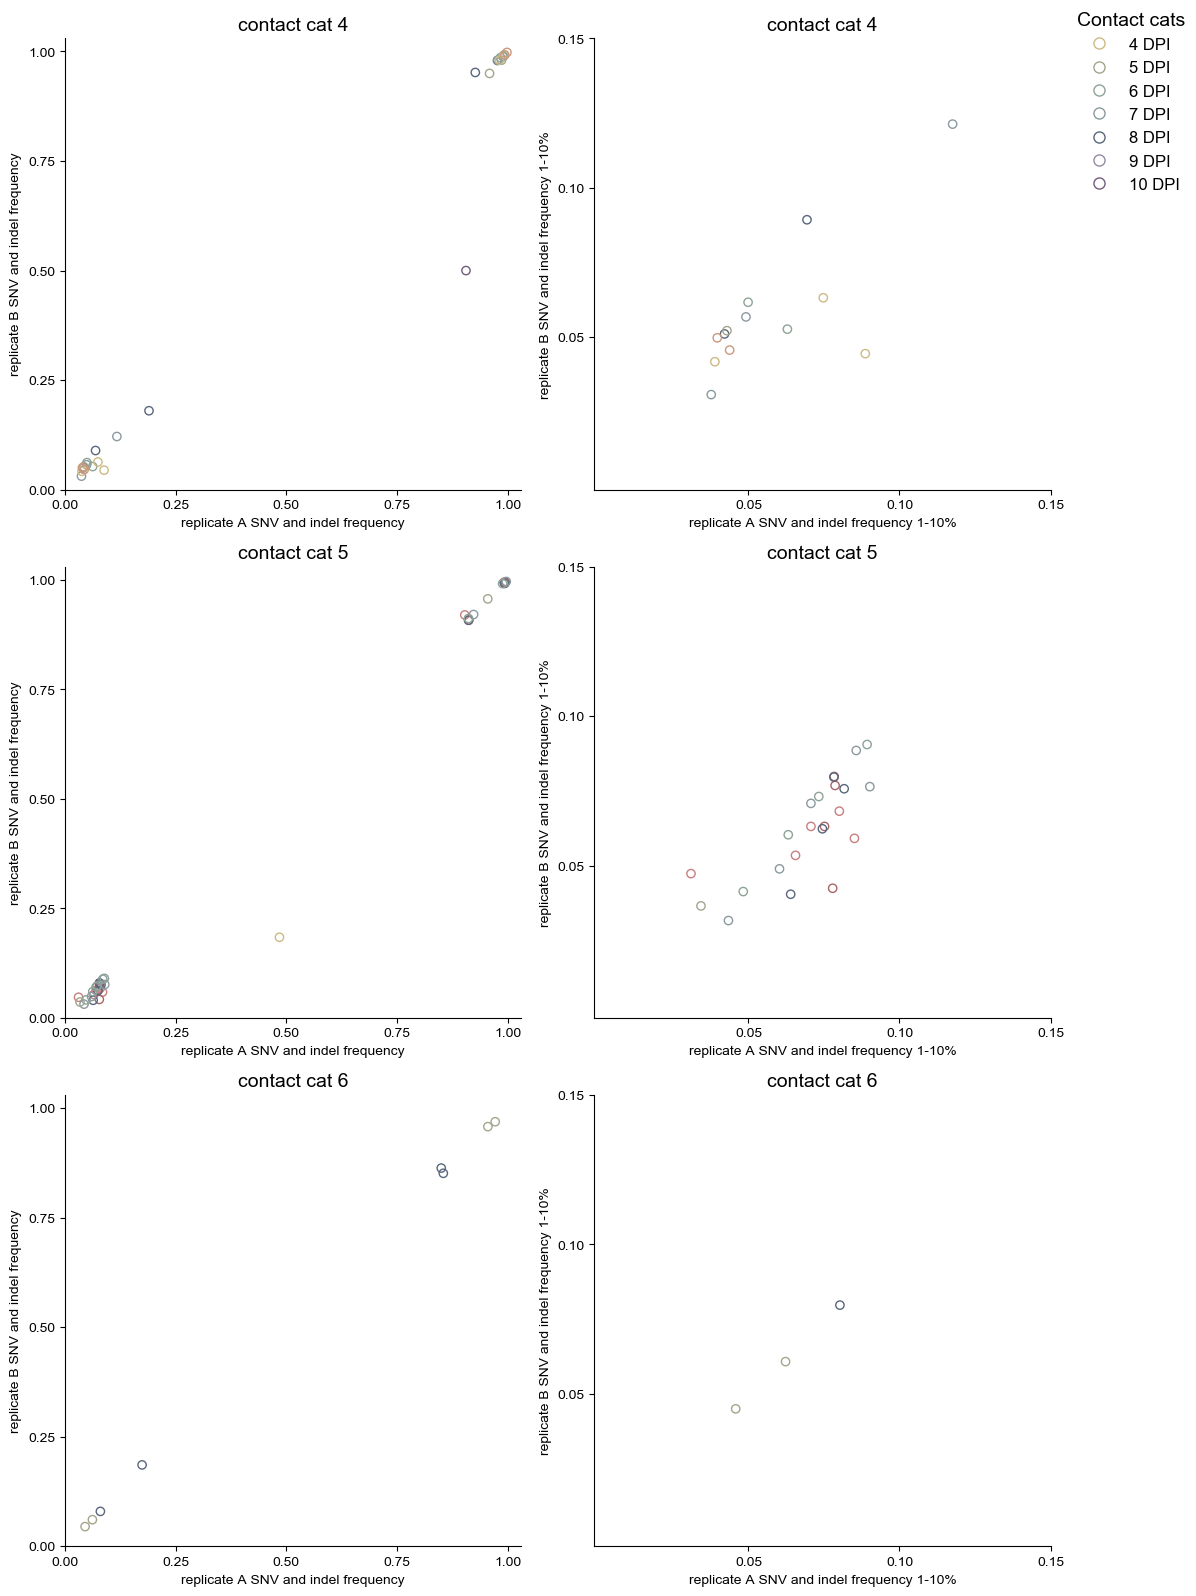

In [56]:
fig1 = plt.figure(figsize=(16,16), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(3, 12)

ax1 = fig1.add_subplot(gs[0,0:4]) # JT/TV plot - Cat 4
ax2 = fig1.add_subplot(gs[0,4:8]) # JT/TV plot ZOOM - Cat 4

ax3 = fig1.add_subplot(gs[1,0:4]) # JT/TV plot - Cat 5
ax4 = fig1.add_subplot(gs[1,4:8]) # JT/TV plot ZOOM - Cat 5

ax5 = fig1.add_subplot(gs[2,0:4]) # JT/TV plot - Cat 6
ax6 = fig1.add_subplot(gs[2,4:8]) # JT/TV plot ZOOM - Cat 6

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(True)
ax3.spines['left'].set_visible(True)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_visible(True)
ax4.spines['left'].set_visible(True)

ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(True)
ax5.spines['left'].set_visible(True)
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.spines['bottom'].set_visible(True)
ax6.spines['left'].set_visible(True)

# load DFs
df4_3 = pd.read_csv("../data_derived/cleaned/4_3-intersection.csv", header=0, sep='\t')
df4_4 = pd.read_csv("../data_derived/cleaned/4_4-intersection.csv", header=0, sep='\t')
df4_5 = pd.read_csv("../data_derived/cleaned/4_5-intersection.csv", header=0, sep='\t')
df4_6 = pd.read_csv("../data_derived/cleaned/4_6-intersection.csv", header=0, sep='\t')
df4_7 = pd.read_csv("../data_derived/cleaned/4_7-intersection.csv", header=0, sep='\t')
df4_8 = pd.read_csv("../data_derived/cleaned/4_8-intersection.csv", header=0, sep='\t')
df4_9 = pd.read_csv("../data_derived/cleaned/4_9-intersection.csv", header=0, sep='\t')
df4_10 = pd.read_csv("../data_derived/cleaned/4_10-intersection.csv", header=0, sep='\t')

df5_3 = pd.read_csv("../data_derived/cleaned/5_3-intersection.csv", header=0, sep='\t')
df5_4 = pd.read_csv("../data_derived/cleaned/5_4-intersection.csv", header=0, sep='\t')
df5_5 = pd.read_csv("../data_derived/cleaned/5_5-intersection.csv", header=0, sep='\t')
df5_6 = pd.read_csv("../data_derived/cleaned/5_6-intersection.csv", header=0, sep='\t')
df5_7 = pd.read_csv("../data_derived/cleaned/5_7-intersection.csv", header=0, sep='\t')
df5_8 = pd.read_csv("../data_derived/cleaned/5_8-intersection.csv", header=0, sep='\t')
df5_9 = pd.read_csv("../data_derived/cleaned/5_9-intersection.csv", header=0, sep='\t')
df5_10 = pd.read_csv("../data_derived/cleaned/5_10-intersection.csv", header=0, sep='\t')

# df6_3 = pd.read_csv("../data_derived/cleaned/6_3-intersection.csv", header=0, sep='\t')
df6_4 = pd.read_csv("../data_derived/cleaned/6_4-intersection.csv", header=0, sep='\t')
df6_5 = pd.read_csv("../data_derived/cleaned/6_5-intersection.csv", header=0, sep='\t')
df6_6 = pd.read_csv("../data_derived/cleaned/6_6-intersection.csv", header=0, sep='\t')
df6_7 = pd.read_csv("../data_derived/cleaned/6_7-intersection.csv", header=0, sep='\t')
df6_8 = pd.read_csv("../data_derived/cleaned/6_8-intersection.csv", header=0, sep='\t')
df6_9 = pd.read_csv("../data_derived/cleaned/6_9-intersection.csv", header=0, sep='\t')
df6_10 = pd.read_csv("../data_derived/cleaned/6_10-intersection.csv", header=0, sep='\t')
    
# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

ax3.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax3.tick_params(axis = 'both', which = 'minor', labelsize = 10)
ax4.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax4.tick_params(axis = 'both', which = 'minor', labelsize = 10)

ax5.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax5.tick_params(axis = 'both', which = 'minor', labelsize = 10)
ax6.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax6.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# FOR PLOT replicate plot
ax1.scatter(df4_10.rep1_percent, df4_10.rep2_percent, edgecolor=colors10, facecolor='none')
ax2.scatter(df4_10.rep1_percent, df4_10.rep2_percent, edgecolor=colors10, facecolor='none')

ax1.scatter(df4_9.rep1_percent, df4_9.rep2_percent, edgecolor=colors9, facecolor='none')
ax2.scatter(df4_9.rep1_percent, df4_9.rep2_percent, edgecolor=colors9, facecolor='none')

ax1.scatter(df4_8.rep1_percent, df4_8.rep2_percent, edgecolor=colors8, facecolor='none')
ax2.scatter(df4_8.rep1_percent, df4_8.rep2_percent, edgecolor=colors8, facecolor='none')

ax1.scatter(df4_7.rep1_percent, df4_7.rep2_percent, edgecolor=colors7, facecolor='none')
ax2.scatter(df4_7.rep1_percent, df4_7.rep2_percent, edgecolor=colors7, facecolor='none')

ax1.scatter(df4_6.rep1_percent, df4_6.rep2_percent, edgecolor=colors6, facecolor='none')
ax2.scatter(df4_6.rep1_percent, df4_6.rep2_percent, edgecolor=colors6, facecolor='none')

ax1.scatter(df4_5.rep1_percent, df4_5.rep2_percent, edgecolor=colors5, facecolor='none')
ax2.scatter(df4_5.rep1_percent, df4_5.rep2_percent, edgecolor=colors5, facecolor='none')

ax1.scatter(df4_4.rep1_percent, df4_4.rep2_percent, edgecolor=colors4, facecolor='none')
ax2.scatter(df4_4.rep1_percent, df4_4.rep2_percent, edgecolor=colors4, facecolor='none')

ax1.scatter(df4_3.rep1_percent, df4_3.rep2_percent, edgecolor=colors3, facecolor='none')
ax2.scatter(df4_3.rep1_percent, df4_3.rep2_percent, edgecolor=colors3, facecolor='none')

ax3.scatter(df5_10.rep1_percent, df5_10.rep2_percent, edgecolor=colors2, facecolor='none')
ax4.scatter(df5_10.rep1_percent, df5_10.rep2_percent, edgecolor=colors2, facecolor='none')

ax3.scatter(df5_9.rep1_percent, df5_9.rep2_percent, edgecolor=colors1, facecolor='none')
ax4.scatter(df5_9.rep1_percent, df5_9.rep2_percent, edgecolor=colors1, facecolor='none')

ax3.scatter(df5_8.rep1_percent, df5_8.rep2_percent, edgecolor=colors8, facecolor='none')
ax4.scatter(df5_8.rep1_percent, df5_8.rep2_percent, edgecolor=colors8, facecolor='none')

ax3.scatter(df5_7.rep1_percent, df5_7.rep2_percent, edgecolor=colors7, facecolor='none')
ax4.scatter(df5_7.rep1_percent, df5_7.rep2_percent, edgecolor=colors7, facecolor='none')

ax3.scatter(df5_6.rep1_percent, df5_6.rep2_percent, edgecolor=colors6, facecolor='none')
ax4.scatter(df5_6.rep1_percent, df5_6.rep2_percent, edgecolor=colors6, facecolor='none')

ax3.scatter(df5_5.rep1_percent, df5_5.rep2_percent, edgecolor=colors5, facecolor='none')
ax4.scatter(df5_5.rep1_percent, df5_5.rep2_percent, edgecolor=colors5, facecolor='none')

ax3.scatter(df5_4.rep1_percent, df5_4.rep2_percent, edgecolor=colors4, facecolor='none')
ax4.scatter(df5_4.rep1_percent, df5_4.rep2_percent, edgecolor=colors4, facecolor='none')

ax3.scatter(df5_3.rep1_percent, df5_3.rep2_percent, edgecolor=colors3, facecolor='none')
ax4.scatter(df5_3.rep1_percent, df5_3.rep2_percent, edgecolor=colors3, facecolor='none')

ax5.scatter(df6_10.rep1_percent, df6_10.rep2_percent, edgecolor=colors2, facecolor='none')
ax6.scatter(df6_10.rep1_percent, df6_10.rep2_percent, edgecolor=colors2, facecolor='none')

ax5.scatter(df6_9.rep1_percent, df6_9.rep2_percent, edgecolor=colors9, facecolor='none')
ax6.scatter(df6_9.rep1_percent, df6_9.rep2_percent, edgecolor=colors9, facecolor='none')

ax5.scatter(df6_8.rep1_percent, df6_8.rep2_percent, edgecolor=colors8, facecolor='none')
ax6.scatter(df6_8.rep1_percent, df6_8.rep2_percent, edgecolor=colors8, facecolor='none')

ax5.scatter(df6_7.rep1_percent, df6_7.rep2_percent, edgecolor=colors7, facecolor='none')
ax6.scatter(df6_7.rep1_percent, df6_7.rep2_percent, edgecolor=colors7, facecolor='none')

ax5.scatter(df6_6.rep1_percent, df6_6.rep2_percent, edgecolor=colors6, facecolor='none')
ax6.scatter(df6_6.rep1_percent, df6_6.rep2_percent, edgecolor=colors6, facecolor='none')

ax5.scatter(df6_5.rep1_percent, df6_5.rep2_percent, edgecolor=colors5, facecolor='none')
ax6.scatter(df6_5.rep1_percent, df6_5.rep2_percent, edgecolor=colors5, facecolor='none')

ax5.scatter(df6_4.rep1_percent, df6_4.rep2_percent, edgecolor=colors4, facecolor='none')
ax6.scatter(df6_4.rep1_percent, df6_4.rep2_percent, edgecolor=colors4, facecolor='none')

# ax5.scatter(df6_3.rep1_percent, df6_3.rep2_percent, edgecolor=colors3, facecolor='none')
# ax6.scatter(df6_3.rep1_percent, df6_3.rep2_percent, edgecolor=colors3, facecolor='none')

# edit the axes - ax1
ax1.set_title('contact cat 4', fontname='Arial', fontsize=14)
ax1.set_ylabel('replicate B SNV and indel frequency', fontname='Arial', fontsize=10)
ax1.set_xlabel('replicate A SNV and indel frequency', fontname='Arial', fontsize=10)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(0.001,1.03)
ax1.set_yticks([0, 0.25, 0.50, 0.75, 1.0])
ax1.set_xlim(0.001,1.03)
ax1.set_xticks([0, 0.25, 0.50, 0.75, 1.0])

ax3.set_title('contact cat 5', fontname='Arial', fontsize=14)
ax3.set_ylabel('replicate B SNV and indel frequency', fontname='Arial', fontsize=10)
ax3.set_xlabel('replicate A SNV and indel frequency', fontname='Arial', fontsize=10)
ax3.set_facecolor('white')
for tick in ax3.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax3.get_yticklabels():
    tick.set_fontname("Arial")
ax3.set_ylim(0.001,1.03)
ax3.set_yticks([0, 0.25, 0.50, 0.75, 1.0])
ax3.set_xlim(0.001,1.03)
ax3.set_xticks([0, 0.25, 0.50, 0.75, 1.0])

ax5.set_title('contact cat 6', fontname='Arial', fontsize=14)
ax5.set_ylabel('replicate B SNV and indel frequency', fontname='Arial', fontsize=10)
ax5.set_xlabel('replicate A SNV and indel frequency', fontname='Arial', fontsize=10)
ax5.set_facecolor('white')
for tick in ax5.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax5.get_yticklabels():
    tick.set_fontname("Arial")
ax5.set_ylim(0.001,1.03)
ax5.set_yticks([0, 0.25, 0.50, 0.75, 1.0])
ax5.set_xlim(0.001,1.03)
ax5.set_xticks([0, 0.25, 0.50, 0.75, 1.0])

# edit the axes - ax2
ax2.set_title('contact cat 4', fontname='Arial', fontsize=14)
ax2.set_ylabel('replicate B SNV and indel frequency 1-10%', fontname='Arial', fontsize=10)
ax2.set_xlabel('replicate A SNV and indel frequency 1-10%', fontname='Arial', fontsize=10)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(-0.001, 0.15)
ax2.set_yticks([0.05, 0.1, 0.15])
ax2.set_xlim(-0.001, 0.15)
ax2.set_xticks([0.05, 0.1, 0.15])

ax4.set_title('contact cat 5', fontname='Arial', fontsize=14)
ax4.set_ylabel('replicate B SNV and indel frequency 1-10%', fontname='Arial', fontsize=10)
ax4.set_xlabel('replicate A SNV and indel frequency 1-10%', fontname='Arial', fontsize=10)
ax4.set_facecolor('white')
for tick in ax4.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax4.get_yticklabels():
    tick.set_fontname("Arial")
ax4.set_ylim(-0.001, 0.15)
ax4.set_yticks([0.05, 0.1, 0.15])
ax4.set_xlim(-0.001, 0.15)
ax4.set_xticks([0.05, 0.1, 0.15])

ax6.set_title('contact cat 6', fontname='Arial', fontsize=14)
ax6.set_ylabel('replicate B SNV and indel frequency 1-10%', fontname='Arial', fontsize=10)
ax6.set_xlabel('replicate A SNV and indel frequency 1-10%', fontname='Arial', fontsize=10)
ax6.set_facecolor('white')
for tick in ax6.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax6.get_yticklabels():
    tick.set_fontname("Arial")
ax6.set_ylim(-0.001, 0.15)
ax6.set_yticks([0.05, 0.1, 0.15])
ax6.set_xlim(-0.001, 0.15)
ax6.set_xticks([0.05, 0.1, 0.15])

# legend 
# sample6_3 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors3, linestyle='None', markersize=8, label='3 DPI')
sample6_4 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors4, linestyle='None', markersize=8, label='4 DPI')
sample6_5 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors5, linestyle='None', markersize=8, label='5 DPI')
sample6_6 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors6, linestyle='None', markersize=8, label='6 DPI')
sample6_7 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors7, linestyle='None', markersize=8, label='7 DPI')
sample6_8 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors8, linestyle='None', markersize=8, label='8 DPI')
sample6_9 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors9, linestyle='None', markersize=8, label='9 DPI')
sample6_10 = mlines.Line2D([], [], marker='o', markerfacecolor='none', color=colors10, linestyle='None', markersize=8, label='10 DPI')


fig1.legend(title='Contact cats',title_fontsize=14,handles=[sample6_4, sample6_5, sample6_6, sample6_7, sample6_8, sample6_9, sample6_10], frameon=False, fontsize=12, bbox_to_anchor=(.75, 1))
   
# use tight_layout to optimize spacing of axes and titles within each subplot
fig1.tight_layout()
fig1.show()
fig1.savefig("../figures/intersection_contact_cats.svg", bbox_inches='tight', dpi=300)